In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
from scipy.stats import poisson
from scipy.stats import betabinom

In [3]:
from random import random
from tqdm.notebook import tqdm

### Read data & preprocessing

In [4]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [5]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

In [6]:
df_ref

SRR3934349  SRR3934350  SRR3934351  SRR3934352  \
chromosome locus                                                       
chr1       629782             62           0           9          25   
           631861              0           0           6           5   
           633792             92          30          40         138   
           633801             94          27          37         139   
           634233              4           0           2           3   
...                          ...         ...         ...         ...   
chrX       154778966           0           0           0           0   
           154801469           0           0           0           0   
           155051675           0           0          47          47   
           155061890           0           0           8          32   
           155943589           0           0           0           3   

                      SRR3934353  SRR3934354  SRR3934355  SRR3934356  \
chromosome locus                                                       
chr1       629782             20          71          13          10   
           631861             15          36           2           6   
           633792            308         342          17          46   
           633801            301         330          17          46   
           634233             16           9           0           0   
...                          ...         ...         ...         ...   
chrX       154778966           0          34           1           0   
           154801469           0           0           0           0   
           155051675           0           0          17           0   
           155061890           0           0           9           0   
           155943589           0           0           4           0   

                      SRR3934357  SRR3934358  ...  SRR3935507  SRR3935508  \
chromosome locus                              ...                           
chr1       629782             29           0  ...           6           2   
           631861             11           0  ...           0          21   
           633792            151           0  ...          73          43   
           633801            140           0  ...          75          42   
           634233              3           0  ...           0           0   
...                          ...         ...  ...         ...         ...   
chrX       154778966           0           0  ...           0           0   
           154801469           0           0  ...           0           0   
           155051675           0          22  ...           0          40   
           155061890           0           0  ...           0           0   
           155943589           0           6  ...          16          11   

                      SRR3935509  SRR3935510  SRR3935511  SRR3935512  \
chromosome locus                                                       
chr1       629782              4          20           1           3   
           631861              1           0           0           0   
           633792              9          34           0          23   
           633801              9          33           0          22   
           634233              1           1           0           0   
...                          ...         ...         ...         ...   
chrX       154778966           0           0           0           0   
           154801469           0           0           0           0   
           155051675           0           0           0           0   
           155061890           0           0           0           0   
           155943589           0          19           0          11   

                      SRR3935513  SRR3935514  SRR3935515  SRR3935516  
chromosome locus                                                      
chr1       629782             21          23           3           

### Utility functions

In [7]:
from scipy.special import loggamma

def logbinom(n, k): 
    return loggamma(n+1) - loggamma(k+1) - loggamma(n-k+1)

# TODO: function overload to combine log_add and log_sum? 
# TODO: returns nan when both values are inf or -inf. Could this be a problem? 
def log_add(a: float, b: float): 
    if a > b: # a < b might result in overflow, hence case distinction
        return a + np.log(1 + np.exp(b-a))
    else: 
        return b + np.log(1 + np.exp(a-b))
    # return max(a,b) + np.log(1 + np.exp(-abs(a - b))) # alternative implementation, seems to be slower
    
def log_sum(lst): 
    result = lst[0]
    for i in range(1, len(lst)): 
        result = log_add(result, lst[i])
    return result

### Data generator

### Mutation detection

In [8]:
ref = np.array(df_ref.loc['chr1',:], dtype = float)
alt = np.array(df_alt.loc['chr1',:], dtype = float)
coverages = ref.flatten() + alt.flatten()

In [9]:
def read_likelihood(n_ref, n_alt, genotype, log_scale = True): 
    f = 0.95
    omega = 100
    if genotype == 'R': 
        alpha = f * omega
        beta = omega - alpha
    elif genotype == 'A': 
        alpha = (1 - f) * omega
        beta = omega - alpha
    elif genotype == 'H': 
        alpha = omega/4 
        beta = omega/4 
    
    if log_scale: 
        return np.log(betabinom.pmf(n_ref, n_ref + n_alt, alpha, beta))
    else: 
        return betabinom.pmf(n_ref, n_ref + n_alt, alpha, beta)


def locus_likelihood(ref, alt, genotypes):
    result = 0.
    for i in range(len(ref)): 
        result += read_likelihood(ref[i], alt[i], genotypes[i])
    return result

In [10]:
def likelihood_n_mut(ref, alt, gt1, gt2, log_scale = True): 
    '''
    ref, alt: read counts for a single locus
    gt1, gt2: genotypes of interest
    '''
    N = ref.size # number of cells
    
    if log_scale: 
        # likelihoods[n, k]: log-likelihood that k of the first n cells have gt2 (and n-k of them have gt1), given the first n observations
        likelihoods = np.ones((N+1, N+1)) * (-np.inf) 
        likelihoods[0,0] = 0 # Trivial case when there is 0 cell: number of gt2 cells must be 0

        for n in tqdm(range(N)): 
            likelihoods[n+1, 0] = likelihoods[n, 0] + read_likelihood(ref[n], alt[n], gt1)
            for k in range(n+1): 
                likelihoods[n+1, k+1] = log_add(likelihoods[n, k+1] + read_likelihood(ref[n], alt[n], gt1), likelihoods[n, k] + read_likelihood(ref[n], alt[n], gt2)) - logbinom(n+1, k+1)
    else: 
        likelihoods = np.zeros((N+1, N+1))
        likelihoods[0,0] = 1

        for n in tqdm(range(N)): 
            likelihoods[n+1, 0] = likelihoods[n, 0] * read_likelihood(ref[n], alt[n], gt1, log_scale = False)
            for k in range(n+1): 
                likelihoods[n+1, k+1] = (likelihoods[n, k+1] * read_likelihood(ref[n], alt[n], gt1, log_scale = False) + likelihoods[n, k] * read_likelihood(ref[n], alt[n], gt2, log_scale = False)) / sp.special.comb(n+1, k+1)
    
    
    return likelihoods[N, :]

In [11]:
ref_test = ref[0,:100]
alt_test = alt[0,:100]

In [12]:
likelihood_n_mut(ref_test, ref_test, 'R', 'H', log_scale = True)

  0%|          | 0/100 [00:00<?, ?it/s]

array([-1838.44472539, -1831.41893769, -1829.55740893, -1827.95435554,
       -1829.48675888, -1834.09997782, -1849.7012304 , -1865.18535132,
       -1880.48216265, -1894.84688442, -1908.57743796, -1925.13303347,
       -1941.17957705, -1958.85699859, -1987.43491101, -2014.24852587,
       -2039.66058282, -2064.55217872, -2092.67007311, -2119.86651109,
       -2149.81500032, -2183.86532269, -2224.0973841 , -2263.41842317,
       -2300.75813849, -2337.03850003, -2372.95323348, -2411.16358632,
       -2452.6239105 , -2492.25888281, -2530.42643007, -2566.67056932,
       -2601.30450001, -2634.78351783, -2670.80619639, -2705.42169566,
       -2738.37094534, -2777.74597331, -2816.35513811, -2854.58452278,
       -2893.80718782, -2935.67364042, -2974.56097569, -3014.42570254,
       -3049.09381686, -3085.37479599, -3119.65561989, -3151.69084741,
       -3185.13067238, -3119.04017203, -3049.20710165, -2981.5022239 ,
       -2911.55794966, -2844.26491946, -2775.44070386, -2706.03447141,
      

In [14]:
def get_priors(n_cells, genotype_freq, mutation_rate):
    '''
    genotype_freq: dictionary, prior probability that the root has genotype R, H or A
    mutation_rate: proportion of mutated loci
    
    returns priors for RH mixture and AH mixture
    '''
    
    state_freq = {s: None for s in ['RR', 'HH', 'AA', 'RH', 'HR', 'AH', 'HA']}
    # state_freq = pd.DataFrame(data = np.zeros(7), columns = ['frequency'], index = ['RR', 'HH', 'AA', ''])
    state_freq['RR'] = genotype_freq['R'] * (1 - mutation_rate)
    state_freq['HH'] = genotype_freq['H'] * (1 - mutation_rate)
    state_freq['AA'] = genotype_freq['A'] * (1 - mutation_rate)
    state_freq['RH'] = genotype_freq['R'] * mutation_rate 
    state_freq['HR'] = genotype_freq['H'] * mutation_rate/2 
    state_freq['AH'] = genotype_freq['A'] * mutation_rate 
    state_freq['HA'] = genotype_freq['H'] * mutation_rate/2
    # convert into log space
    for s in state_freq: 
        state_freq[s] = np.log(state_freq[s])
    
    priors_k_mutated = np.zeros(n_cells+1) 
    for k in range(1, n_cells+1):
        priors_k_mutated[k] = 2 * logbinom(n_cells, k) - np.log(2*k-1) - logbinom(2*n_cells, 2*k)
    
    result = np.ones(2*n_cells + 1) * (-np.inf) # R --- RH --- H --- HA --- A
    result[0] = state_freq['RR']
    result[n_cells] = state_freq['HH']
    result[-1] = state_freq['AA']
    for k in range(1, n_cells+1): 
        result[k] = log_add(result[k], state_freq['RH'] + priors_k_mutated[k])
        result[n_cells - k] = log_add(result[n_cells - k], state_freq['HR'] + priors_k_mutated[k])
        result[-k-1] = log_add(result[-k-1], state_freq['AH'] + priors_k_mutated[k])
        result[n_cells + k] = log_add(result[n_cells + k], state_freq['HA'] + priors_k_mutated[k])
    
    return result[:n_cells+1], result[n_cells:]
    

def get_posteriors(ref, alt, RH_priors, HA_priors): 
    RH = likelihood_n_mut(ref, alt, 'R', 'H', log_scale = True)
    HA = likelihood_n_mut(ref, alt, 'H', 'A', log_scale = True)
    
    result = pd.DataFrame(np.zeros(5), columns = ['posterior'], index = ['RR', 'RH', 'HH', 'HA', 'AA'])
    result.loc['RR'] = RH[0] + RH_priors[0]
    result.loc['RH'] = log_sum(RH[1:-1] + RH_priors[1:-1])
    result.loc['HH'] = HA[0] + HA_priors[0]
    result.loc['HA'] = log_sum(HA[1:-1] + HA_priors[1:-1])
    result.loc['AA'] = HA[-1] + HA_priors[-1]
    
    normalizing_factor = log_sum(result.to_numpy())
    result['posterior'] -= normalizing_factor
    result['posterior'] = np.exp(result['posterior'])
    
    return result

In [18]:
RH_priors, HA_priors = get_priors(n_cells = len(ref[0,:]), genotype_freq = {'R':1/3, 'H': 1/3, 'A': 1/3}, mutation_rate = 0.25)
get_posteriors(ref[0,:], alt[0,:], RH_priors, HA_priors)

  0%|          | 0/1168 [00:00<?, ?it/s]

  0%|          | 0/1168 [00:00<?, ?it/s]

,posterior
RR,0.999978
RH,0.000022
HH,0.000000
HA,0.000000
AA,0.000000


In [ ]:
genotype_freq = np.array[1/3, 1/3, 1/3] # prior for the root genotypes
mutation_rate = 0.1 # proportion of mutated loci




### LOH detection

### SVD Imputation

In [67]:
# X: data matrix in which rows (dimension 0) are samples and columns (dimension 1) are features
def mean_impute(X): 
    X_imputed = X.copy() 
    for i in range(X.shape[1]): 
        feature = X[:,i] 
        mean = np.nanmean(feature) # take mean of the feature, ignoring NaN
        if np.isnan(mean): 
            print('[Mean Imputation] WARNING: Empty feature at column %d.'%i) 
        nan_indices = np.where(np.isnan(feature))[0] 
        X_imputed[nan_indices,i] = mean 
    return X_imputed 


def zero_impute(X): 
    X_imputed = X.copy()
    X_imputed[np.isnan(X)] = 0
    return X_imputed
    

def svd_impute(X, rank = None, tol = 0.1, max_iter = 100):
    if rank is None: 
        rank = min(X.shape) // 2
    
    nan_indices = np.where(np.isnan(X))
    X_imputed = zero_impute(X) #initialise all nan entries with the a mean imputation
    
    for i in tqdm(range(max_iter)):
        X_old = X_imputed.copy()
        L,D,R = np.linalg.svd(X_imputed)
        X_approx = L[:,:rank] @ np.diag(D[:rank]) @ R[:rank,:] #rank r approximation of X_imputed
        X_imputed[nan_indices] = X_approx[nan_indices]
        fnorm = np.linalg.norm(X_old - X_imputed, ord="fro")
        if fnorm < tol:
            print('[SVD Imputation]: Converged after %d iterations.'%(i+1))
            print('Frobenius norm:', fnorm)
            break
        if (i+1) >= max_iter:
            print('[SVD Imputation]: Maximum number (%d) of iterations reached.'%(i+1))
            print('Frobenius norm:', fnorm)
    
    return X_imputed

In [17]:
ref.shape

(1702, 1168)

In [28]:
np.sum(alt > 5, axis = 1)

array([ 0, 63, 40, ...,  1,  1, 84])

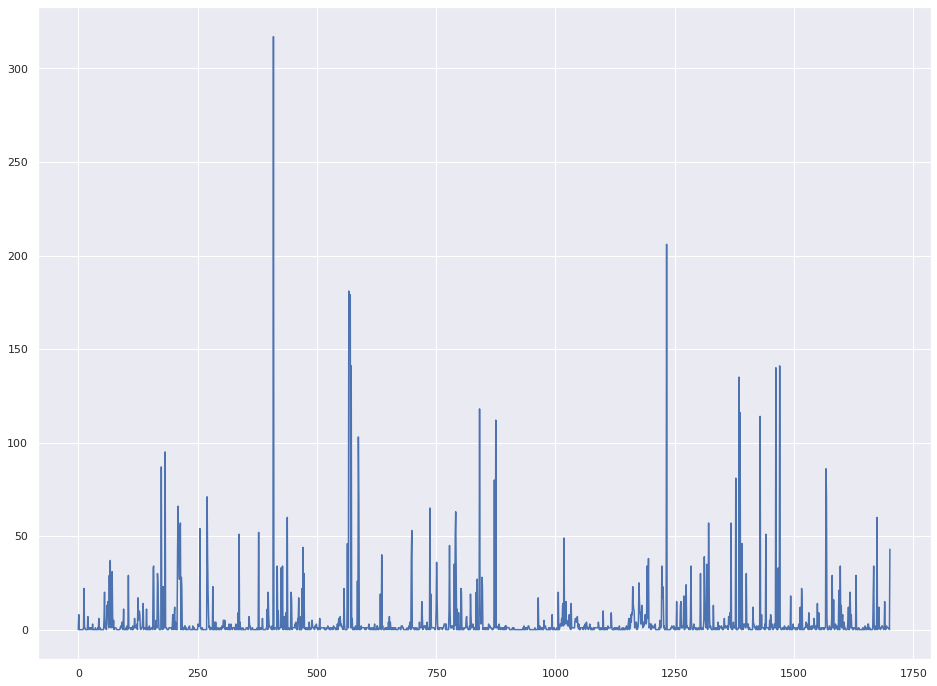

In [32]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (16, 12))
    plt.plot(np.sum(alt > 16, axis = 1))
    plt.show()

In [ ]:
for i in range(ref.shape[0]): 
    for j in range(ref.shape[1]): 
        if ref[i,j] == 0 and alt[i,j] == 0:
            ref[i,j] = np.nan
            alt[i,j] = np.nan

In [73]:
X = np.concatenate([ref, alt], axis = 1)
X_imputed = svd_impute(X, rank = 5)

100%|█████████████████████████████████████████████████████████████| 100/100 [06:03<00:00,  3.63s/it]

[SVD Imputation]: Maximum number (100) of iterations reached.
Frobenius norm: 196.81055642117263


In [74]:
X_imputed.shape

(1702, 2336)

In [75]:
ref_imputed = X_imputed[:,:ref.shape[1]]
alt_imputed = X_imputed[:,ref.shape[1]:]

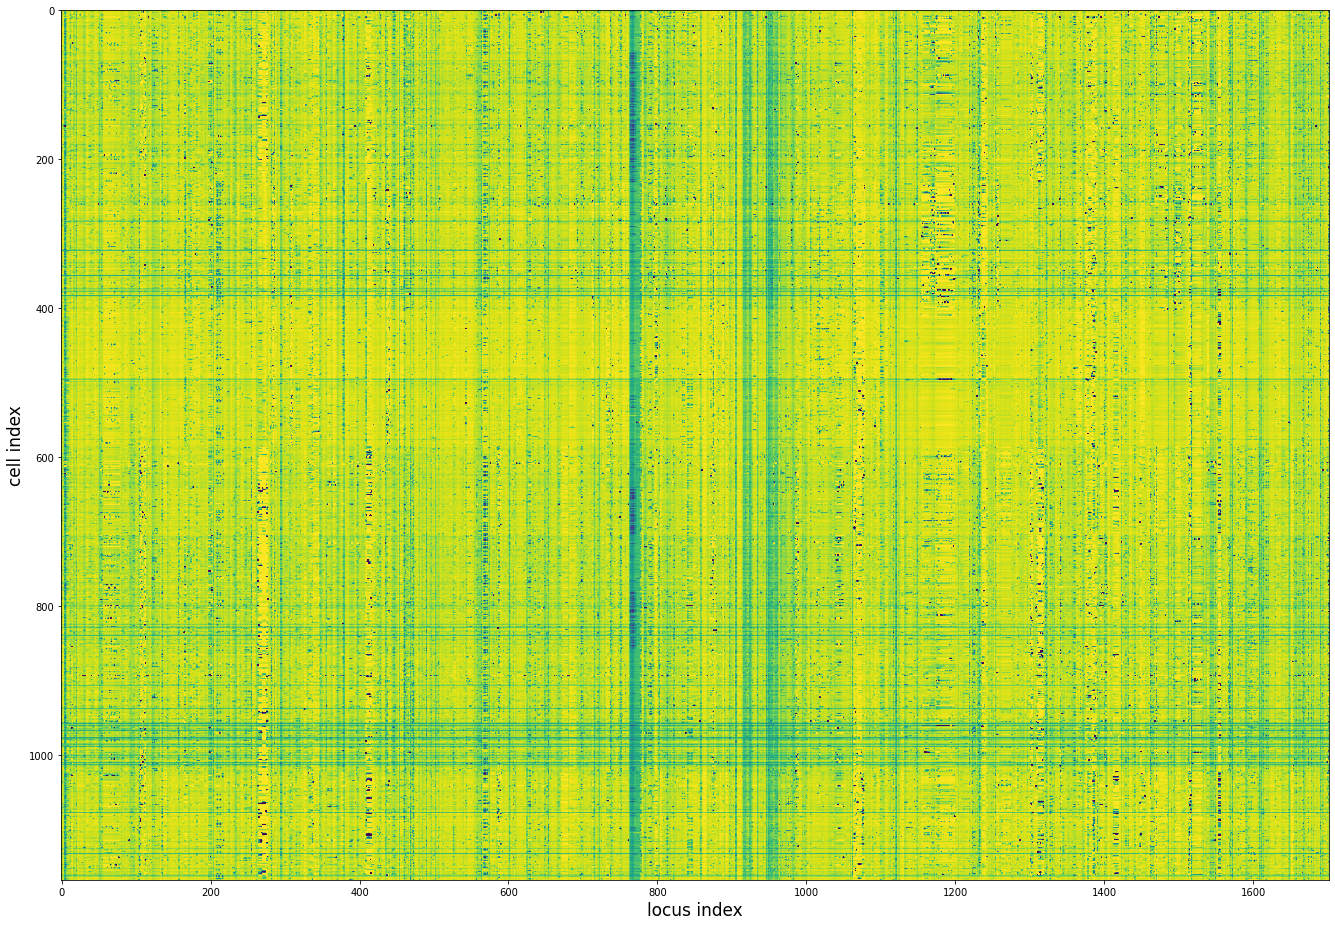

In [76]:
ref_proportion = (ref_imputed + 1) / (ref_imputed + alt_imputed + 2)

plt.figure(figsize=(24,16))
plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1.) 
# "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
plt.xlabel('locus index', fontsize = 17)
plt.ylabel('cell index', fontsize = 17)
plt.show()

### HMM

In [12]:
# I: initial probability
# T: transition probability (including the begin state)
# E: emission probability
# X: observation
def viterbi(I, T, E, X):
    length = X.shape[0]
    n_states = X.shape[1]
    v = np.zeros((length, n_states)) # v[j, k] = max joint probability having k at step j and emission X[i]
    
    v[0,:] = np.array([I[i] * E(i, X[0]) for i in range(n_states)])
    for j in range(1, length):
        for k in range(n_states):
            v[j,k] = E(k, X[j]) * np.max([v[j-1,l] * T(l,k) for l in range(n_states)]) # l: assumed state of previous step
    
    best_path = np.argmax(v, axis = 1)
    
    return best_path, v[-1, best_path[-1]] # second return is the max joint probability

In [13]:
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

In [14]:
def E(state, obs, f = 0.7, omega = 10):
    n_ref = obs[0]
    coverage = np.sum(obs)
    if state == 1: # normal (heterozygous)
        alpha = (1/2 - 2/3 * f) / omega
        beta = omega - alpha
    elif state == 2: # LOH
        alpha = f * omega
        beta = omega - alpha
    else: 
        print('\n ERROR: invalid state \n')
        return
    
    return betabinom.pmf(n_ref, coverage, alpha, beta)

In [15]:
X = np.stack((np.array(df_ref.loc['chr1',:])[0,:], np.array(df_alt.loc['chr1',:])[0,:])).T
X

array([[62,  0],
       [ 0,  0],
       [ 9,  0],
       ...,
       [23,  0],
       [ 3,  0],
       [ 3,  0]])